# Занятие 09
# Обзор AutoML решений. Введение в тестирование гипотез

This notebook is brought to you by Radoslav Neychev

#### План занятия

1. Разведочный анализ и предобработка данных
2. Построение baseline решения
3. Обзор AutoML решений:
    * TPOT
    * H2O AutoML
    * Google AutoML
4. Анализ ошибки

## Recap: какой природы бывают данные?
Данные следующей природы часто встречаются в прикладных задачах
* __Табличные данные__. Классическая ситуация: на каждой строке отдельный объект, каждый столбец – некоторый признак, описывающий этот объект. Бывают мультикоррелирующие признаки. Информация кроется в значениях признаков. Перестановка признаков местами (перестановка столбцов) ни на что не влияет.

* __Изображения__. Данные – изображения, состоящие из пикселей. Каждое изображение обладает пространственной структурой, информация кроется в том, как пиксели упорядочены. Перестановка пикселей приводит к потере информации.

* __Последовательности__. Данные – наборы значений, на которых задано отношение порядка. Значения могут быть дискретными (например, ДНК), или же могут принимать значения из непрерывного интервала (временной ряд энергопотребления дата центра). Перестановка значений приводит к потере информации. Нельзя нарушать отношение порядка (тестирование на прошлом, обучение на будущем).

* __Тексты__. Данные – наборы слов/символов. По факту являются последовательностями значений из конечного алфавита, но обладают достаточно строгой внутренней структурой ввиду существования грамматики.

* __Графы__. Данные – набор вершин и связей между ними. Связь между парой вершин означает наличие некоторого отношения между этими вершинами, которое может быть как направленным, так и ненаправленным. Например, в социальной сети вершинами могут являться пользователи, пользователи находящиеся в списке друзей друг у друга связаны ребрами типа "дружба". Подписчики связаны с пользовтелем, на которого они подписаны направленным ребром типа "подписка".

* __Данные сложной природы__. Например, видео – последовательность изображений; граф социальной сети, где для каждого пользователя доступны не только списки друзей и подписчиков, но и фотография/аватар, некоторые высказывания и пр.

In [ ]:
! pip install --upgrade --user google-cloud-automl --force-reinstall --quiet
! pip install --upgrade --user google-cloud-bigquery --force-reinstall --quiet
! pip install --upgrade --user google-cloud-storage --force-reinstall --quiet
! pip install --upgrade --user matplotlib --quiet
! pip install --upgrade --user pandas --quiet
! pip install --upgrade --user pandas-gbq --quiet
! pip install --upgrade --user gcsfs --force-reinstall --quiet

In [ ]:
! pip install tpot
! pip install h2o

In [4]:
import json
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


matplotlib.rcParams.update({"font.size": 15})

from IPython.display import clear_output


print(f"Python version: {sys.version}\n")
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from plotly import graph_objects as go


sns.set(style="ticks", context="talk")
import plotly.express as px
import plotly.io as pio
from IPython.display import HTML
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

Python version: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]



In [5]:
# Dark plots
# plt.style.use('dark_background')
# pio.templates.default = "plotly_dark"

## Работа с данными
Рассмотрим табличные данные о [поведении клиентов онлайн-магазина](https://www.kaggle.com/roshansharma/online-shoppers-intention) [1]. На основании информации о посетитиле необходимо предсказать, будет ли совершена покупка, т.е. решается задача бинарной классификации.

Ответим на следующие вопросы:
* Есть ли пропуски в данных?
* Сбалансированны ли классы?
* С какими типами данных предстоит работать?





1. [Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018)](https://link.springer.com/article/10.1007%2Fs00521-018-3523-0)

In [7]:
dataset = pd.read_csv(
    "https://github.com/girafe-ai/ml-mipt/raw/f42e10661880c405d76796c7418cfec08d241309/datasets/online_shoppers_intention/online_shoppers_intention.csv"
)

Набор данных небольших размеров:

In [8]:
dataset.shape

(12330, 18)

In [9]:
dataset.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [10]:
dataset.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

В некоторых наблюдениях есть пропуски, но их количество незначительно.

In [11]:
dataset.isna().sum() / len(dataset)

Administrative             0.001135
Administrative_Duration    0.001135
Informational              0.001135
Informational_Duration     0.001135
ProductRelated             0.001135
ProductRelated_Duration    0.001135
BounceRates                0.001135
ExitRates                  0.001135
PageValues                 0.000000
SpecialDay                 0.000000
Month                      0.000000
OperatingSystems           0.000000
Browser                    0.000000
Region                     0.000000
TrafficType                0.000000
VisitorType                0.000000
Weekend                    0.000000
Revenue                    0.000000
dtype: float64

Исключим наблюдения с пропусками:

In [12]:
dataset = dataset.dropna()

In [13]:
dataset.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.895952,0.061497,2.124147,2.357584,3.148019,4.070477
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.577926,0.199020,0.911566,1.718028,2.402211,4.024598
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12316 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12316 non-null  float64
 9   SpecialDay               12316 non-null  float64
 10  Month                    12316 non-null  object 
 11  OperatingSystems         12316 non-null  int64  
 12  Browser                  12316 non-null  int64  
 13  Region                   12316 non-null  int64  
 14  TrafficType           

Также в данных наблюдаются категориальные переменные. Перечислим их.

In [15]:
categorical_features = [
    "OperatingSystems",
    "Browser",
    "Region",
    "TrafficType",
    "Month",
    "VisitorType",
]

In [16]:
for feature_name in categorical_features:
    dataset[feature_name] = dataset[feature_name].astype("category")

### Визуальный анализ данных

Text(0.5, 1.0, 'Different classes')

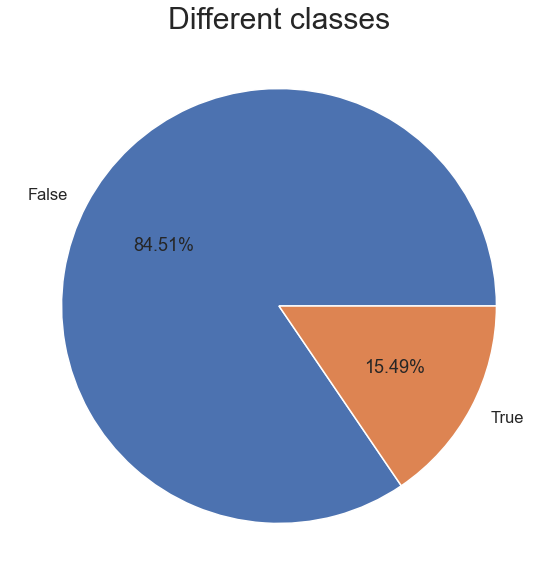

In [17]:
class_counts = dataset["Revenue"].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(class_counts.values, labels=class_counts.index, autopct="%.2f%%")
plt.title("Different classes", fontsize=30)

Стоит рассмотреть распределения значений признаков в зависимости от значения целевой переменной.

In [18]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    """
    Code origin: https://www.kaggle.com/kageyama/lgbm-online-shopper-s-eda-and-classification
    """
    i = 0
    sns.set_style("whitegrid")
    plt.figure()
    fig, ax = plt.subplots(3, 3, figsize=(18, 22))

    for feature in features:
        i += 1
        plt.subplot(3, 3, i)
        sns.distplot(df1[feature], hist=True, label=label1)
        sns.distplot(df2[feature], hist=True, label=label2)
        plt.xlabel(feature, fontsize=14)
        locs, labels = plt.xticks()
        plt.tick_params(axis="x", which="major", labelsize=12, pad=-6)
        plt.tick_params(axis="y", which="major", labelsize=12)
        plt.legend()
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/ml-mipt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/ml-mipt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/ml-mipt/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

<Figure size 432x288 with 0 Axes>

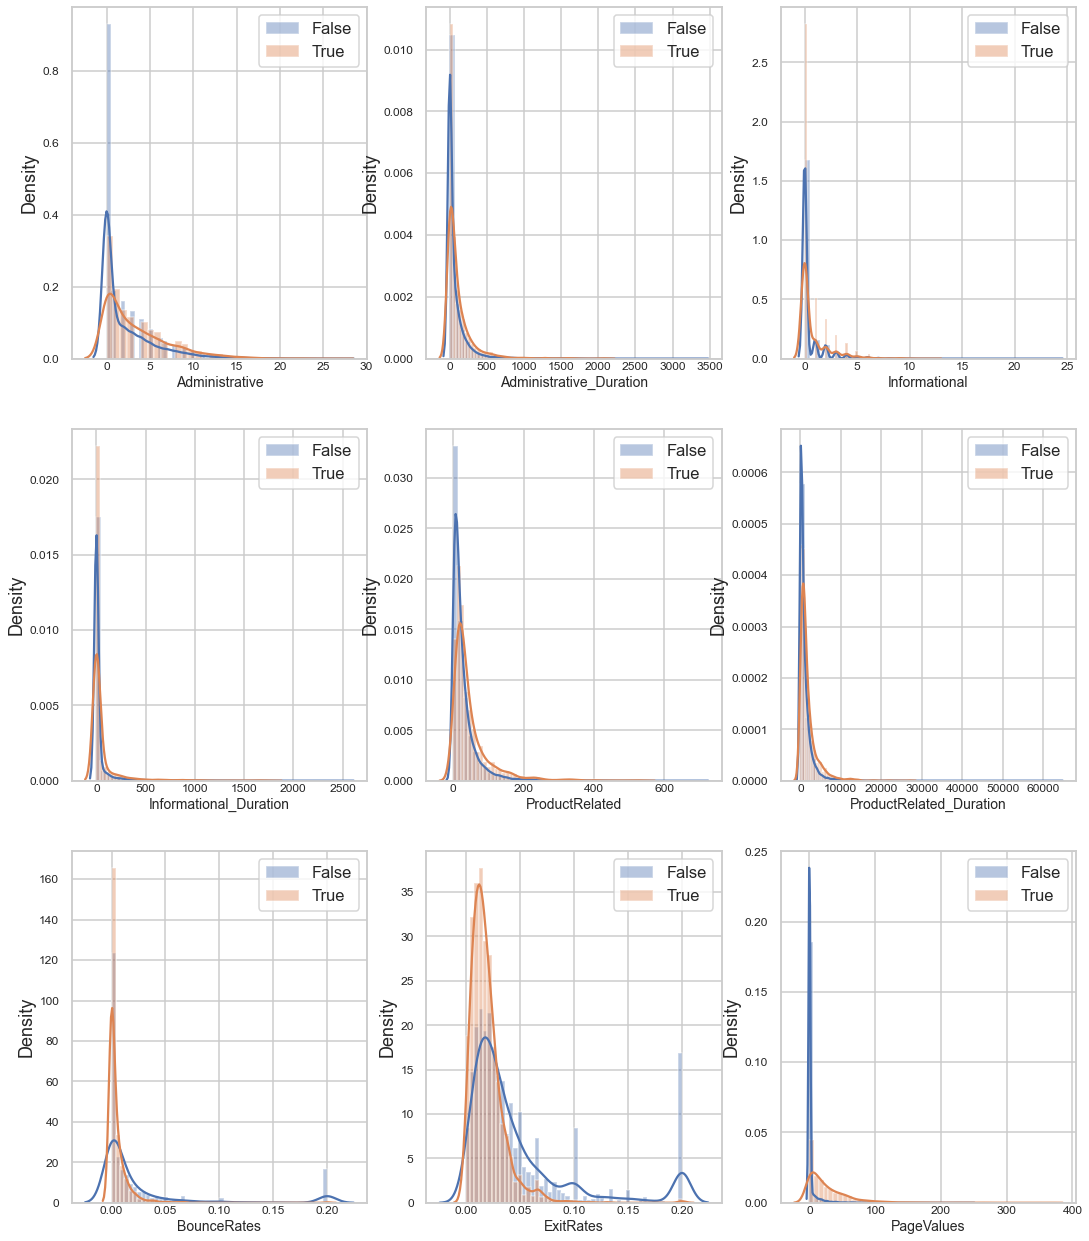

In [19]:
t0 = dataset.loc[dataset["Revenue"] == True]
t1 = dataset.loc[dataset["Revenue"] == False]
features = dataset.columns.values[:9]
plot_feature_distribution(t1, t0, "False", "True", features)

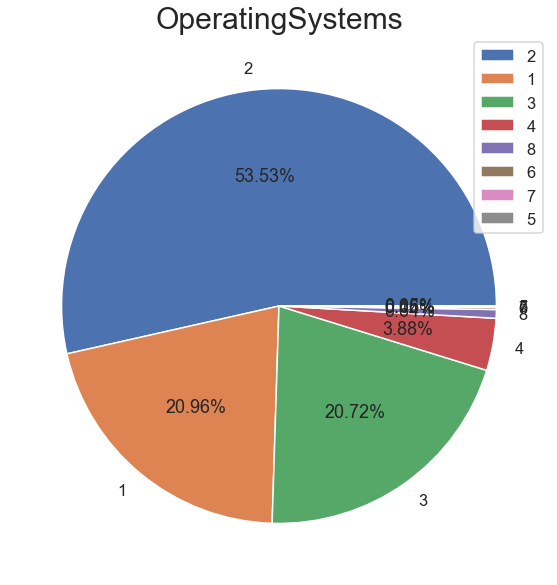

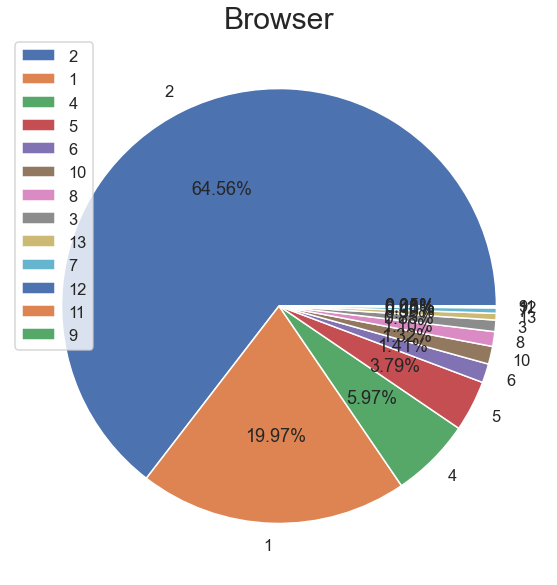

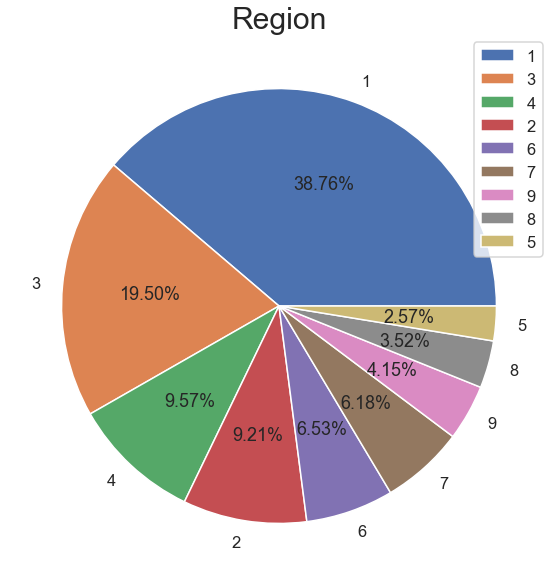

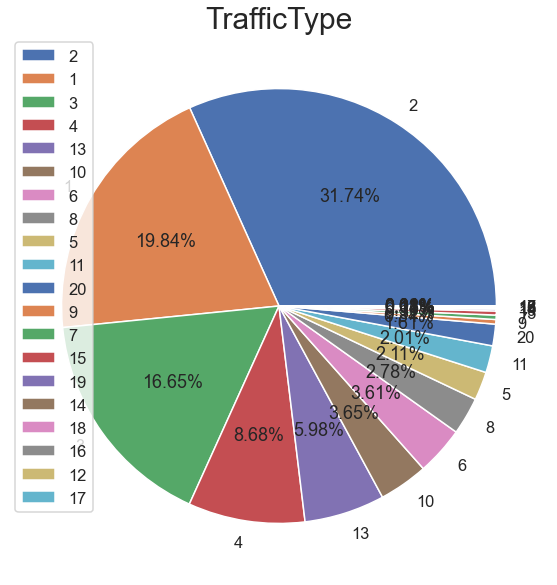

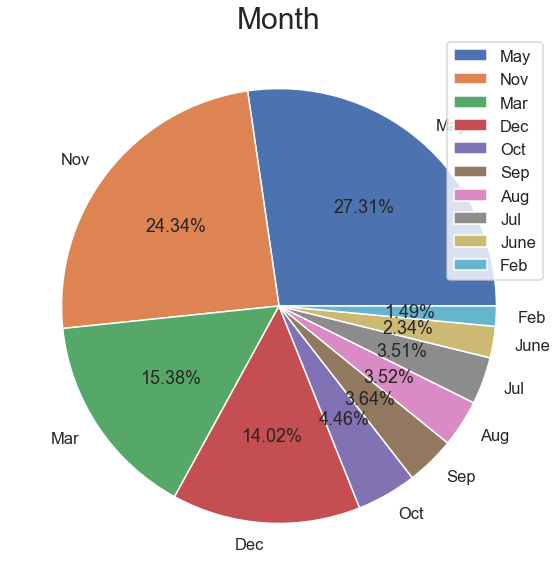

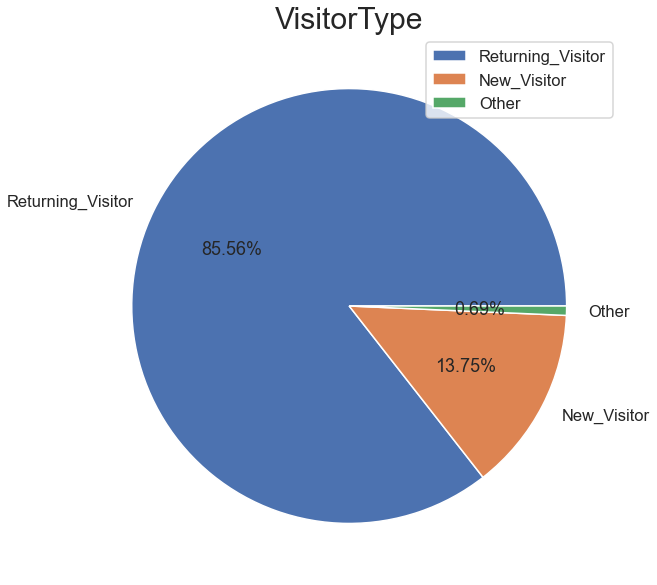

In [20]:
for feature_name in categorical_features:
    counts = dataset[feature_name].value_counts()
    plt.figure(figsize=(10, 10))
    plt.pie(counts.values, labels=counts.index, autopct="%.2f%%")
    plt.legend()
    plt.title(feature_name, fontsize=30)
    plt.show()

In [21]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    """
    Code origin: https://www.kaggle.com/kageyama/lgbm-online-shopper-s-eda-and-classification
    """
    i = 0
    sns.set_style("whitegrid")
    plt.figure()
    fig, ax = plt.subplots(3, 3, figsize=(18, 22))

    for feature in features:
        i += 1
        plt.subplot(3, 3, i)
        sns.distplot(df1[feature], hist=True, label=label1)
        sns.distplot(df2[feature], hist=True, label=label2)
        plt.xlabel(feature, fontsize=14)
        locs, labels = plt.xticks()
        plt.tick_params(axis="x", which="major", labelsize=12, pad=-6)
        plt.tick_params(axis="y", which="major", labelsize=12)
        plt.legend()
    plt.show()

## Предобработка данных
Некоторые модели умеют работать с категориальными признаками (напирмер, [CatBoost]()), но частый этап предобработки – кодирование категориальных признаков. Категориальная переменная может быть представлена как множество бинарных (индикатор каждого значения). Существуют и [другие методы](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder)  работы с категориальными признаками.

Воспользуемся простым методом `.get_dummies`.

In [22]:
dataset = pd.get_dummies(dataset, columns=categorical_features)

In [23]:
dataset.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Weekend',
       'Revenue', 'OperatingSystems_1', 'OperatingSystems_2',
       'OperatingSystems_3', 'OperatingSystems_4', 'OperatingSystems_5',
       'OperatingSystems_6', 'OperatingSystems_7', 'OperatingSystems_8',
       'Browser_1', 'Browser_2', 'Browser_3', 'Browser_4', 'Browser_5',
       'Browser_6', 'Browser_7', 'Browser_8', 'Browser_9', 'Browser_10',
       'Browser_11', 'Browser_12', 'Browser_13', 'Region_1', 'Region_2',
       'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8',
       'Region_9', 'TrafficType_1', 'TrafficType_2', 'TrafficType_3',
       'TrafficType_4', 'TrafficType_5', 'TrafficType_6', 'TrafficType_7',
       'TrafficType_8', 'TrafficType_9', 'TrafficType_10', 'TrafficType_11',
       'TrafficType_12', 'TrafficType_13', 'TrafficT

In [24]:
target = dataset["Revenue"]
feature_matrix = dataset.drop(columns=["Revenue"])

При разделении данных на обучающую и тестовую выборки стоит учесть дисбаланс классов. Для этого воспользуемся стратификацией.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, target, random_state=0, stratify=target.values
)

In [26]:
X_train.shape

(9237, 74)

In [27]:
X_test.shape

(3079, 74)

## Построение простого baseline-решения
В качестве baseline-решения будет использоваться Random Forest Classifier c параметрами по умолчанию.

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
rf = RandomForestClassifier()

In [30]:
rf.fit(X_train, y_train)

RandomForestClassifier()

Baseline (Random Forest with defauld hyperparameters) results:


Train balanced accuracy: 1.00000
Test  balanced accuracy: 0.73410

Train ROC AUC: 1.00000
Test  ROC AUC: 0.92422

              precision    recall  f1-score   support

       False    0.91344   0.96925   0.94052      2602
        True    0.74843   0.49895   0.59874       477

    accuracy                        0.89639      3079
   macro avg    0.83093   0.73410   0.76963      3079
weighted avg    0.88787   0.89639   0.88757      3079



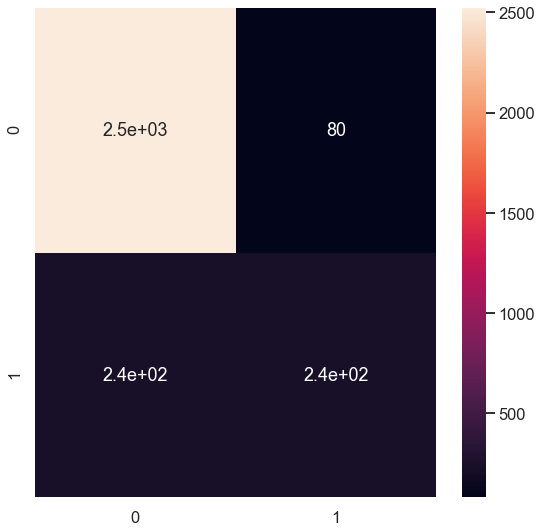

In [31]:
print("Baseline (Random Forest with defauld hyperparameters) results:\n\n")


print(
    "Train balanced accuracy: {:0.5f}".format(balanced_accuracy_score(y_train, rf.predict(X_train)))
)
print(
    "Test  balanced accuracy: {:0.5f}".format(balanced_accuracy_score(y_test, rf.predict(X_test)))
)
print()
print("Train ROC AUC: {:0.5f}".format(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])))
print("Test  ROC AUC: {:0.5f}".format(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])))
print()

# confusion matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
plt.rcParams["figure.figsize"] = (9, 9)
sns.heatmap(cm, annot=True)

# classification report
cr = classification_report(y_test, rf.predict(X_test), digits=5)
print(cr)

__Судя по качеству на обучающей выборке, модель переобучилась. Также стоит учесть, что классы несбалансированны.__

## AutoML
### TPOT

Данная библиотека упрощает _прототипирование_ , в том числе с помощью `sklearn`. Подробнее можно почитать [здесь [en]](https://epistasislab.github.io/tpot/), [здесь [en]](http://automl.info/tpot/) или [здесь [en]](https://towardsdatascience.com/tpot-automated-machine-learning-in-python-4c063b3e5de9).
Библиотека крайне проста в использовании. Одним из плюсов данной библиотеки является возможность импортировать не только лучшую обученную модель, но и программный код, который ее обучает.

_Комментарий: Для использования AutoML на больших объемах данных необходимы серьезные вычислительные мощности._

In [32]:
from tpot import TPOTClassifier

In [ ]:
# create & fit TPOT classifier with
tpot = TPOTClassifier(generations=10, population_size=10, verbosity=2, early_stop=2, n_jobs=10)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9015911493307269

Generation 2 - Current best internal CV score: 0.9015911493307269


Для экспортирования программного для обучения лучшей модели необходимо указать имя файла:

In [ ]:
# save our model code
tpot.export("tpot_pipeline.py")

Можно провести визуальный анализ кода.

In [ ]:
!cat tpot_pipeline.py

Для сравнения полученной модели с baseline (Random Forest) обратимся к использовавшимся ранее методам.

In [ ]:
print("TPOT AutoML results:\n\n")
print(
    "Train balanced accuracy: {:0.5f}".format(
        balanced_accuracy_score(y_train, tpot.predict(X_train))
    )
)
print(
    "Test  balanced accuracy: {:0.5f}".format(balanced_accuracy_score(y_test, tpot.predict(X_test)))
)
print()
print("Train ROC AUC: {:0.5f}".format(roc_auc_score(y_train, tpot.predict_proba(X_train)[:, 1])))
print("Test  ROC AUC: {:0.5f}".format(roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])))
print()
# confusion matrix
cm = confusion_matrix(y_test, tpot.predict(X_test))
plt.rcParams["figure.figsize"] = (9, 9)
sns.heatmap(cm, annot=True)

# classification report
cr = classification_report(y_test, tpot.predict(X_test), digits=5)
print(cr)

__Обратите внимание на небольшое повышение качества на тестовой выборке и снижения качества на обучающей выборке. 
Полученная модель меньше переобучена.__

### H2O
Библиотека для AutoML от коллектива [H2O](https://www.h2o.ai) достаточно популярна в профессиональной среде (а также в соревнованиях по машинному обучению и анализу данных). Подробнее об `h2o.automl` можно почитать [здесь [ru]](https://neurohive.io/ru/tutorial/tutorial-po-primeneniju-automl-v-h2o-ai-dlya-avtomatizacii-podbora-giperparametrov-modeli/) или [здесь [en]](https://www.h2o.ai/products/h2o-automl/).

_При работе на уже выделенной виртуальной машине на GCP опустим данный пункт (т.к. он требует ручной установки java на уже аллоцированной машине)._

In [ ]:
# import h2o
# from h2o.automl import H2OAutoML

# # initilaize an H20 instance running locally
# h2o.init()

H2O требует некоторой предобработки данных в собственный формат.

In [ ]:
# # convert our data to h20Frame, an alternative to pandas datatables
# train_feature_matrix = h2o.H2OFrame(X_train)
# train_targets = h2o.H2OFrame(list(y_train))
# train_data = train_feature_matrix.cbind(train_targets)

Обучение моделей может занять серьезное время. Random seed зафиксирован для воспроизводимости.

In [ ]:
# # Run AutoML for 20 base models (limited to 1 hour max runtime by default)
# aml = H2OAutoML(max_models=10, seed=0)

In [ ]:
# aml.train(y="C1", training_frame=train_data)

Рейтинг топ-5 моделей доступен ниже.

In [ ]:
# lb = aml.leaderboard
# lb.head(rows=5)

Лучшую модель можно сохранить.

In [ ]:
# h2o.save_model(aml.leader)

Оценим качество модели на отложенной выборке.

In [ ]:
# test_data = h2o.H2OFrame(X_test).cbind(h2o.H2OFrame(list(y_test)))
# out_h2o_train = aml.predict(train_data).as_data_frame()
# out_h2o_test = aml.predict(test_data).as_data_frame()

In [ ]:
# print('H2O AutoML results:\n\n')


# print('Train balanced accuracy: {:0.5f}'.format(balanced_accuracy_score(y_train, out_h2o_train['predict'])))
# print('Test  balanced accuracy: {:0.5f}'.format(balanced_accuracy_score(y_test, out_h2o_test['predict'])))
# print()
# print('Train ROC AUC: {:0.5f}'.format(roc_auc_score(y_train, out_h2o_train['True'])))
# print('Test  ROC AUC: {:0.5f}'.format(roc_auc_score(y_test, out_h2o_test['True'])))
# print()


# # confusion matrix
# cm = confusion_matrix(y_test, out_h2o_test['predict'])
# plt.rcParams['figure.figsize'] = (9, 9)
# sns.heatmap(cm, annot=True)

# # classification report
# cr = classification_report(y_test, out_h2o_test['predict'], digits=5)
# print(cr)

__Полученные результаты превосходят baseline и сопоставимы с результатами TPOT (несколько им уступая).__

## Google AutoML
В отличие от рассмотренных решений, Google AutoML переносит вычисления на собственные вычислительные мощности. Для их использования необходимо активировать данную опцию в настройках Google Cloud Platform. Для активации, загрузки данных и получения доступов, обратитесь к [инструкции [ru]](https://docs.google.com/document/d/1hiGgIGtuisc1FbUZn31B59mkOcDP1YeMw3vyb4108Gg/edit?usp=sharing). В ноутбуке предполагается, что AutoML уже активирован и данные выгружены на GCP.

Также вы можете обратиться к [официальной инструкции](https://cloud.google.com/vision/automl/object-detection/docs/quickstart-ui), где также рассматривается использование AutoML для обучения моделей без написания кода.

In [ ]:
from google.cloud import automl_v1beta1 as automl
from google.cloud import bigquery, storage

In [ ]:
PROJECT_ID = "jovial-style-290414"  # @param {type:"string"}
COMPUTE_REGION = "us-central1"  # Currently only supported region.

_Комментарий: лучше переименовать загруженный ключ и убрать из имени пробелы._

_Для запуска кода ниже на локальной машине необходимо установить `google-cloud-sdk`. Вы можете обратиться к [официальной инструкции](https://cloud.google.com/sdk/docs/install#deb). Не забудьте выбрать инструкцию для используемой системы (Windows/macOS/Debian/Ubuntu/...). Пожалуйста, внимательно прочитайте инструкцию. В случае возникновения ошибок может помочь [этот вопрос на StackOverflow](https://stackoverflow.com/questions/56679191/apt-get-is-broken-after-install-google-cloud-sdk-on-ubuntu-18-04-lts)._

На машине, выделенной на GCP `google-cloud-sdk` уже установлен. 

In [ ]:
%env GOOGLE_APPLICATION_CREDENTIALS MyFirstProject-c1fa9c397fbd.json
! gcloud auth activate-service-account --key-file 'MyFirstProject-c1fa9c397fbd.json'

In [ ]:
BUCKET_NAME = "netology_ai_course_practice/"  # @param {type:"string"}

Данная строчка позволит проверить, что доступ к GCP и наборам данных налажен

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

In [ ]:
DATASET_DISPLAY_NAME = "Netology_practice_3_dataset"
TARGET_COLUMN = "Revenue"


MODEL_DISPLAY_NAME = "automl_practice_model"  # Model name
TRAIN_BUDGET = 1000  # Maximum time to train model in milli-hours

In [ ]:
storage_client = storage.Client(project=PROJECT_ID)
tables_gcs_client = automl.GcsClient(client=storage_client)
tables_client = automl.TablesClient(
    project=PROJECT_ID, region=COMPUTE_REGION, gcs_client=tables_gcs_client
)

In [ ]:
# Select the target column
tables_client.set_target_column(
    dataset_display_name=DATASET_DISPLAY_NAME, column_spec_display_name=TARGET_COLUMN
)

In [ ]:
# let our model know that input columns may have missing values
for col in tables_client.list_column_specs(
    project=PROJECT_ID, dataset_display_name=DATASET_DISPLAY_NAME
):
    if TARGET_COLUMN in col.display_name:
        continue
    tables_client.update_column_spec(
        project=PROJECT_ID,
        dataset_display_name=DATASET_DISPLAY_NAME,
        column_spec_display_name=col.display_name,
        nullable=True,
    )

Далее остается лишь запустить обучение. Выбор модели и настройка параметров будут происходит на стороне GCP, ядро данного ноутбука не будет задействовано.

In [ ]:
# Start model training
response = tables_client.create_model(
    MODEL_DISPLAY_NAME,
    dataset_display_name=DATASET_DISPLAY_NAME,
    train_budget_milli_node_hours=TRAIN_BUDGET,
    exclude_column_spec_names=[TARGET_COLUMN],
)

Процесс обучения можно наблюдать во вкладке Train.

In [ ]:
# When the model is trained, flag will be set True
response.done()

Данная процедура обучения займет некоторое время (порядка одного часа). Сейчас можно продолжить изучение ноутбука. Результаты можно будет проинтерпретировать в дальнейшем.

## Выводы:
* Методы AutoML позволяют значительно ускорить этап прототипирования, а в некоторых случаях добиться хороших результатов.
* Для использования AutoML на реальных данных необходимы значительные вычислительные мощности.
* Облачные провайдеры предоставляют для этого необходимые инструменты, но при использовании данных механизмов на постоянной основе стоит рассмотреть вопрос о переходе да собственные мощности.
* Проверка гипотез и A/B тестирование – мощный инструмент при принятии решений.
* При проведении тестирования стоит очень внимательно подходить к дизайну эксперимента.
* При интерпретации результатов тестирования стоит обращать внимание на множество факторов (мощность критерия, значимость изменений с точки зрения бизнеса, сопутствующие риски и пр.), а не только на $p$-значение.